In [ ]:
# Inspired by micrograd, developed while watching the tutorial videos.

import math
import numpy as np
import matplotlib.pyplot as plt

class Value:
    def __init__ (self, data, children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # initialize gradient to zero
        self._prev = set(children) # set of child nodes
        self._op = _op # operation that produced this node
        self.label = label # optional label for visualization
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            local_deriv = 1.0 if out.data == 0 else out.data
            self.grad += local_deriv * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(tanh, (self,), 'tanh')
        def _backward():
            local_deriv = (1-tanh**2)
            self.grad = local_deriv * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # Build the list of nodes in forward order
        nodes = []
        visited = set()
        def build_nodes(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_nodes(child)
                nodes.append(v)

        build_nodes(self)        
        # We need to traverse backwards through all the nodes of the expression, so reverse the list
        nodes = list(reversed(nodes))
        
        # Initialize the gradient
        self.grad = 1.0
        for node in nodes:
            node._backward()



In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in sorted(nodes, key=lambda x:x.label):
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')


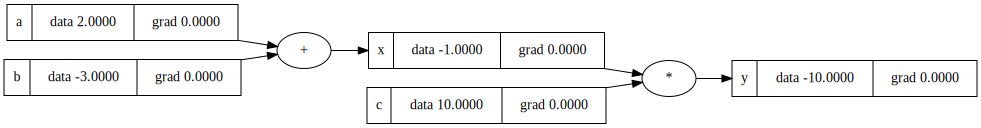

In [ ]:
x = a + b; x.label = 'x'
L = x * c; y.label = 'y'

draw_dot(y)

In [ ]:
# Now we need to implement backpropagation
# Output node L is the loss function - 
# Other nodes are input data, trainable weights or intermediate calcs
# Bump weights to minimize L

0.9999999999621422


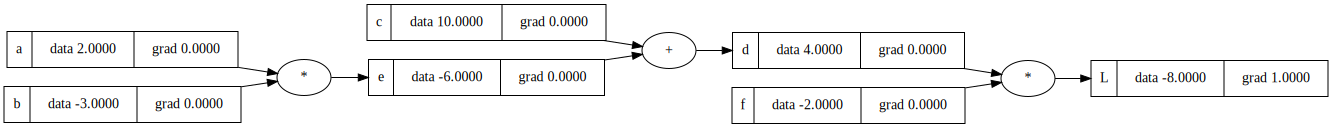

In [22]:
h = .00001 

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'

L1 = L.data
L2 = L.data + h

def dL():
    h = .00001 

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'

    L1 = L.data
    L2 = L.data + h
    
    print((L2-L1)/h)
dL()

L.grad = 1.0

draw_dot(L)

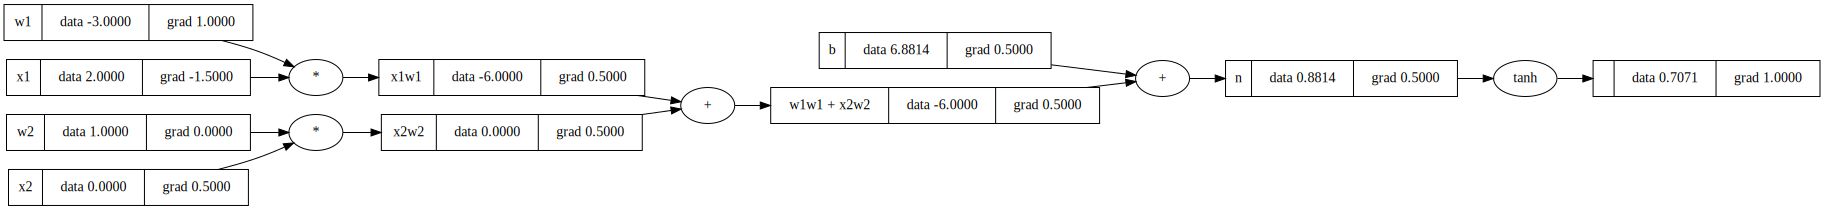

In [70]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#Forward pass
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'w1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

o.backward()

draw_dot(o)
